# QC filtering

This notebook is about filtering scATAC seq data within an adata object to archive a good quality peak matrix.
For this task various QC filters are implemented. The latter includes filters related to:

- doublet score
- number of features per barcode
- mean insert size
- promotor enrichment


## Settings

In [59]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/home/rstudio/processed_data'
test = 'Esophagus'

## QC Settings

In [60]:
filter_xy = True  # True or False; filtering out chrX and chrY
binarize_mtx = True  # True or False; convert matrix to binary
select_hvf = True  # True or False; select only highly variable features

# Highly Variable Features thresholds:
min_limit = 1000
max_limit = 5000

############################# filters with cutoffs ####################################
# if this is True thresholds below are ignored 
only_automatic_thresholds = False # True or False; to use automatic thresholds

# FIXME: NO function in the apply_qc_thresholds function (currently has to be turned off)
# if thresholds None they are set automatically
n_features_filter = False # True or False; filtering out cells with numbers of features not in the range defined below
# default values n_features 
min_features = 5
max_features = 10000

mean_insertsize_filter = True # True or False; filtering out cells with mean insertsize not in the range defined below
# default mean_insertsize
upper_threshold_mis=160 
lower_threshold_mis=80

filter_pct_fp=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default promotor enrichment
upper_threshold_pct_fp=0.4
lower_threshold_pct_fp=0.1

filter_n_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default number of fragments
upper_thr_fragments=200000
lower_thr_fragments=0

filter_chrM_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default number of fragments in chrM
upper_thr_chrM_fragments=10000
lower_thr_chrM_fragments=0

filter_uniquely_mapped_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default number of uniquely mapped fragments
upper_thr_um=20000
lower_thr_um=0



## Sum up settings

In [61]:
manual_thresholds = {}
if n_features_filter:
    manual_thresholds['features'] = {'min' : min_features, 'max' : max_features}

if mean_insertsize_filter:
    manual_thresholds['mean_insertsize'] = {'min' : lower_threshold_mis, 'max' : upper_threshold_mis}

if filter_pct_fp:
    manual_thresholds['pct_fragments_in_promoters'] = {'min' : lower_threshold_pct_fp, 'max' : upper_threshold_pct_fp}

if filter_n_fragments:
    manual_thresholds['TN'] = {'min' : lower_thr_fragments, 'max' : upper_thr_fragments}

if filter_chrM_fragments:
    manual_thresholds['CM'] = {'min' : lower_thr_chrM_fragments, 'max' : upper_thr_chrM_fragments}

if filter_uniquely_mapped_fragments:
    manual_thresholds['UM'] = {'min' : lower_thr_um, 'max' : upper_thr_um}
    
plot_cols = list(manual_thresholds.keys())

## Loading packages and setup

In [62]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.atac_utils import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
import numpy as np

## Setup path handling object 

In [63]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [64]:
# probably updated in future
assembling_output = tree.assembled_anndata
adata = epi.read_h5ad(assembling_output)
adata

AnnData object with n_obs × n_vars = 73652 × 150138
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'name'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

In [65]:
adata.var 

,name
0,b'chr1':10008-10690
1,b'chr1':11179-11381
2,b'chr1':28734-29439
3,b'chr1':29495-29682
4,b'chr1':34673-35029
...,...
150133,b'chrY':57203305-57203488
150134,b'chrY':57206427-57206551
150135,b'chrY':57215321-57215411
150136,b'chrY':57215521-57215837


## hack to visualize nucleosomal signal

In [66]:
#adata.uns['insertsize_distribution'] = adata.uns['insertsize_distribution'].swapaxes('index', 'columns')

In [67]:
#adata.uns['insertsize_distribution']

In [68]:
#atac.plot_insertsize(adata)

# QC

## 1. filtering out chrX, chrY and chrM

In [69]:
non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
adata = adata[:, non_m]

In [70]:
if filter_xy:
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

In [71]:
display(adata)

View of AnnData object with n_obs × n_vars = 73652 × 150138
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'name'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

## 2. removing empty cells and features

In [72]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 71726 × 148047
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'name', 'n_cells'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

## 3. binarize

In [73]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 5. visualize adata

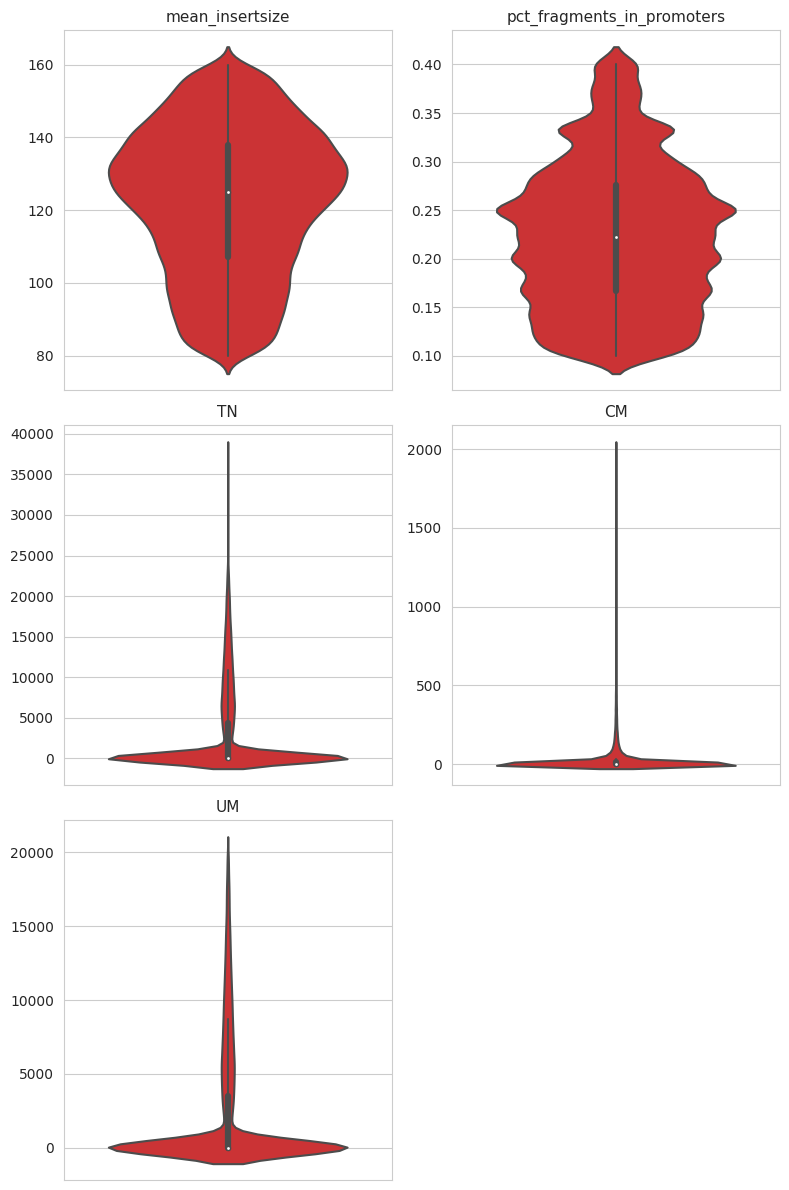

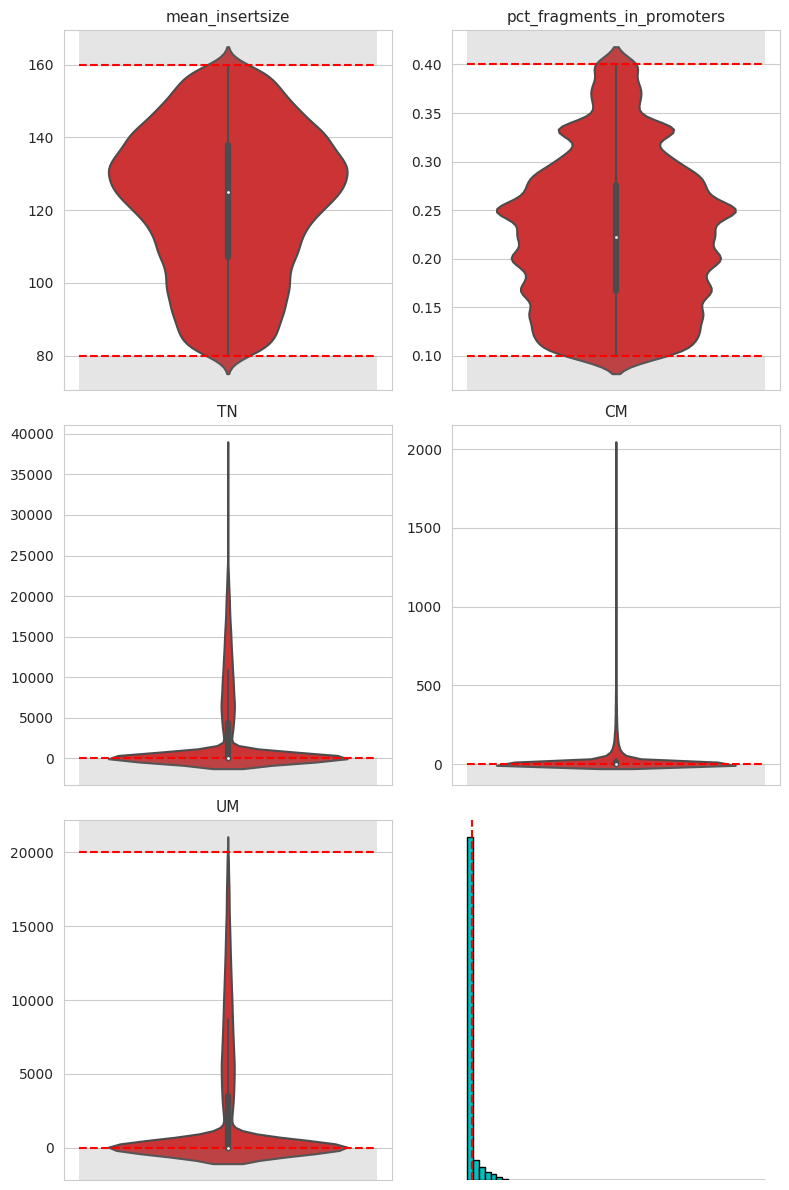

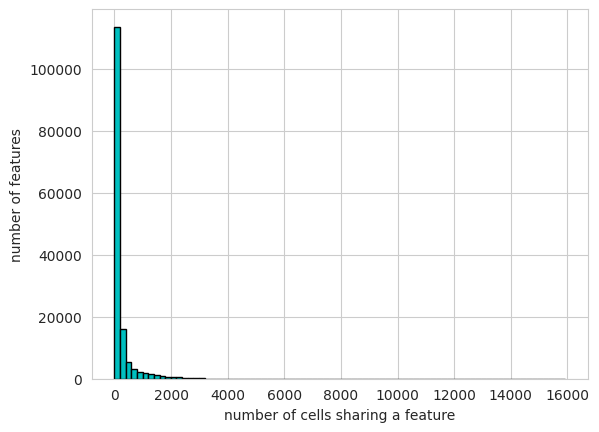


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



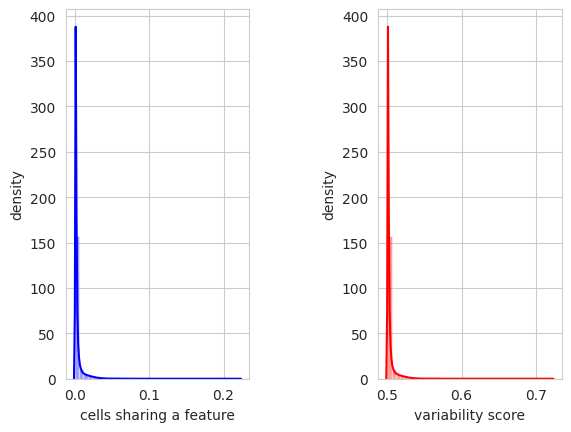

In [74]:
plot_ov_hist(adata, threshold_features=1000) # FIXME: Later plots do not visualize

In [75]:
quality_violin(adata, plot_cols)

(<Figure size 800x1200 with 6 Axes>,
 {'mean_insertsize': {},
  'pct_fragments_in_promoters': {},
  'TN': {},
  'CM': {},
  'UM': {}})

## 6. filter cells

### 6.1 get tresholds dict

In [76]:
thresholds = get_thresholds_atac_wrapper(adata, manual_thresholds, only_automatic_thresholds)
thresholds_as_table(thresholds)

,Parameter,Minimum,Maximum
0,mean_insertsize,80.0,160.0
1,pct_fragments_in_promoters,0.1,0.4
2,TN,0.0,200000.0
3,CM,0.0,10000.0
4,UM,0.0,20000.0


### 6.2 plot thresholds

In [77]:
quality_violin(adata, plot_cols, thresholds=thresholds)

(<Figure size 800x1200 with 6 Axes>,
 {'mean_insertsize': {},
  'pct_fragments_in_promoters': {},
  'TN': {},
  'CM': {},
  'UM': {}})

### 6.3 filter adata

In [78]:
apply_qc_thresholds(adata, thresholds)

Filtering based on 'mean_insertsize' from 71726 -> 53217 cells
Filtering based on 'pct_fragments_in_promoters' from 53217 -> 37680 cells
Filtering based on 'TN' from 37680 -> 37678 cells
Filtering based on 'CM' from 37678 -> 37678 cells
Filtering based on 'UM' from 37678 -> 37068 cells


## 7. save plots

In [79]:
plot_dir = tree.qc_plots
# implement save plots //plot functions have to be modified 

## 8. save adata

In [80]:
adata_output = tree.qc_anndata
adata.write(filename=adata_output)